In [36]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

# Loading Training Data

In [21]:
class SpectrogramDataset(Dataset):
    def __init__(self, pickle_name: str = 'train_data.pickle') -> None:
        self.instru_to_num_dict = {
            "Sound_Guitar": 0,
            "Sound_Drum": 1,
            "Sound_Piano": 2,
        }
        self.num_to_instru_dict = {
            0: "Sound_Guitar",
            1: "Sound_Drum",
            2: "Sound_Piano",
        }
        
        obj = pickle.load(open(f"dataset/{pickle_name}", "rb"))
        self.filenames = obj[0]
        self.spectros = obj[1]
        self.instru_num = torch.tensor(
            list(map(lambda x: self.instru_to_num_dict[x], obj[2]))
        )
        self.data_length = len(self.instru_num)

    def num_to_intrument(self, num):
        return self.num_to_instru_dict[num]

    def __getitem__(self, index):
        return self.spectros[index], self.instru_num[index]

    def __len__(self):
        return self.data_length

In [ ]:
train_dataset = SpectrogramDataset()


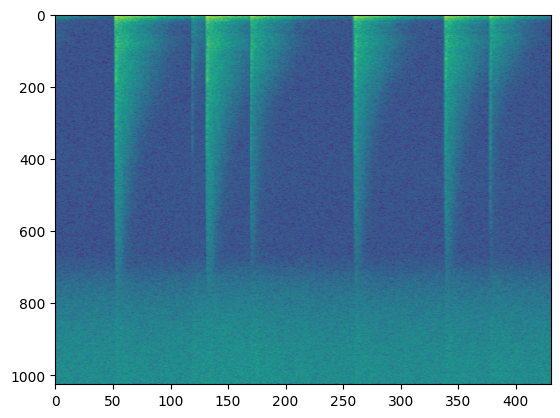

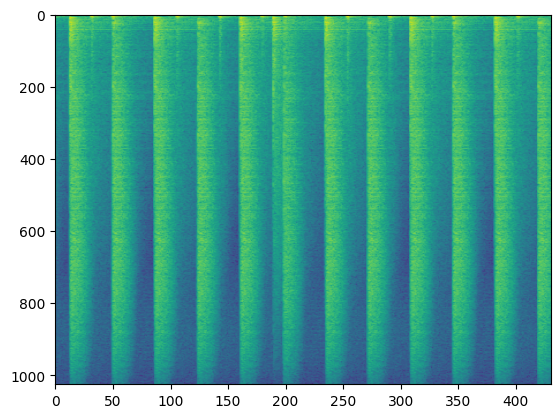

In [24]:

plt.figure()
plt.imshow(train_dataset[4][0], aspect='auto')
plt.figure()
plt.imshow(train_dataset[5][0], aspect='auto')

# Defining the 2D CNN model

Input -> Spectrograms  
Output -> Pre Softmax Probability Distribution for Each Instrument (Guitar, Drums, Piano) 

In [4]:
class InstruConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(526240, 100)
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 3)

    def forward(self, x: torch.Tensor):
        x.unsqueeze_(1) ###
        x = self.conv1(x)
        x = self.pool(self.relu(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 526240)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Optimization Loop

In [ ]:
# Hyperparameters

epochs = 5
lr = 0.001
batch_size = 8

# training

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
CNN_model = InstruConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN_model.parameters(), lr)

loss_list = []

for epoch in range(epochs):
    iters = len(dataloader)
    for n, (features, labels) in enumerate(dataloader):
        outputs = CNN_model(features)
        loss = criterion(outputs, labels) # - sum(outputs[:, -1])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



        loss_item = loss.item()
        loss_list.append(loss_item)

        if (n + 1) % 10 == 0 or n == 0 or n == iters - 1:
            print(
                f"{epoch+1}/{epochs}",
                f"{n+1}/{iters}",
                f"loss = {loss_item}",
                sep="\t",
            )
plt.plot(loss_list)
pickle.dump((CNN_model, loss_list), open("first_trained_model.pickle", "wb"))

# Testing

In [37]:
saved_model, l_list = pickle.load(open("first_trained_model.pickle", "rb"))

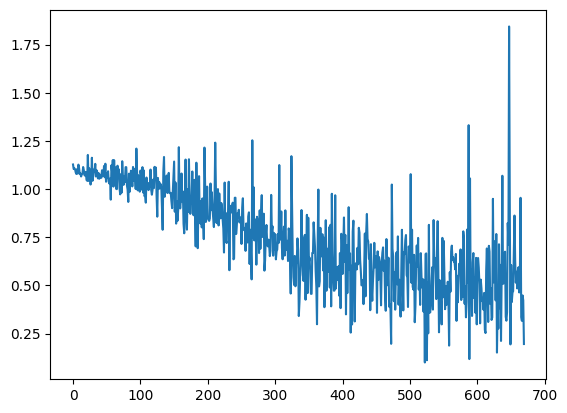

In [38]:
plt.plot(l_list)

In [39]:
test_df = pd.read_csv('dataset/testing_info.csv')
test_df.head()

,FileName,Class,Duration,SampleRate,Channels
0,acoustic-guitar-logo-13084.wav,Sound_Guitar,5.9,44100,2
1,guitar-solo-5999.wav,Sound_Guitar,15.9,44100,1
2,intro-music-black-box-simple-guitar-12701.wav,Sound_Guitar,42.7,44100,2
3,rock_1_100BPM.wav,Sound_Guitar,28.8,44100,1
4,rock_2_100BPM.wav,Sound_Guitar,28.8,44100,1


In [40]:
""" test_meta = pd.read_csv("dataset\Test\Metadata_Test.csv")
test_meta.head()

durations = []
srs = []
channels = []

for filename in test_meta['FileName']:
    waveform, sr = torchaudio.load("archive/Test_submission/Test_submission/"+filename)
    durations.append((len(waveform[0])*10//sr)/10)
    srs.append(sr)
    channels.append(len(waveform))

test_meta["Duration"] = pd.Series(durations)
test_meta["SampleRate"] = pd.Series(srs)
test_meta["Channels"] = pd.Series(channels)
test_meta.head()


test_meta.loc[test_meta["Class"] == "Sound_Guiatr", "Class"] = "Sound_Guitar"
processed_data = test_meta[
    (test_meta["Duration"] >= 5)
    & (test_meta["SampleRate"] == 44100)
    & ~(test_meta["Class"] == "Sound_Violin")
]
processed_data.to_csv("dataset/testing_info.csv", index=False)
plt.hist(processed_data["Class"]) """

' test_meta = pd.read_csv("dataset\\Test\\Metadata_Test.csv")\ntest_meta.head()\n\ndurations = []\nsrs = []\nchannels = []\n\nfor filename in test_meta[\'FileName\']:\n    waveform, sr = torchaudio.load("archive/Test_submission/Test_submission/"+filename)\n    durations.append((len(waveform[0])*10//sr)/10)\n    srs.append(sr)\n    channels.append(len(waveform))\n\ntest_meta["Duration"] = pd.Series(durations)\ntest_meta["SampleRate"] = pd.Series(srs)\ntest_meta["Channels"] = pd.Series(channels)\ntest_meta.head()\n\n\ntest_meta.loc[test_meta["Class"] == "Sound_Guiatr", "Class"] = "Sound_Guitar"\nprocessed_data = test_meta[\n    (test_meta["Duration"] >= 5)\n    & (test_meta["SampleRate"] == 44100)\n    & ~(test_meta["Class"] == "Sound_Violin")\n]\nprocessed_data.to_csv("dataset/testing_info.csv", index=False)\nplt.hist(processed_data["Class"]) '

In [41]:
# obj = pickle.load(open("dataset/processed_data.pickle", "rb"))

In [42]:
""" from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(list(zip(obj[0],obj[1])), obj[2], test_size=0.2)
 """

' from sklearn.model_selection import train_test_split\n\nX_train, X_test, Y_train, Y_test = train_test_split(list(zip(obj[0],obj[1])), obj[2], test_size=0.2)\n '

In [43]:
""" exy = X_train
waiy = Y_train
temp_obj = [
    [exy[i][0] for i in range(len(exy))],
    [exy[i][1] for i in range(len(exy))],
    [waiy[i] for i in range(len(exy))],
]
temp_obj """

' exy = X_train\nwaiy = Y_train\ntemp_obj = [\n    [exy[i][0] for i in range(len(exy))],\n    [exy[i][1] for i in range(len(exy))],\n    [waiy[i] for i in range(len(exy))],\n]\ntemp_obj '

In [44]:
# pickle.dump(temp_obj, open("dataset/train_data.pickle", 'wb'))

In [45]:
test_dataset = SpectrogramDataset('test_data.pickle')

In [46]:
test_dl = DataLoader(test_dataset, 8)

In [47]:
count_right = 0
for i, (data, labels) in enumerate(test_dl):
    outputs = saved_model(data)
    count_right += sum(torch.argmax(outputs, dim=1) == labels)
    # print(labels, torch.argmax(outputs, dim=1) == labels)

print(f'Accuracy on test data = {((count_right*100) / ((i+1) * 8)).item()}%')

Accuracy on test data = 66.17646789550781%
